# Using Pytorch Neural Network Class to Classify MNIST

##  Dataset Introduction
MNIST includes 60,000 28x28 training samples and 10,000 test samples.Many tutorials will start with it, as the "Hello World" problem in Machine Learning.So here we will also use MNIST for practice.

And we will also build a convolutional neural network from scratch, which can achieve an accuracy of 99%.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

First, we define some hyperparameters

In [2]:
BATCH_SIZE = 512 #batch size = the number of training examples in one forward/backward pass
EPOCHS = 10 #an epoch in a neural network is the training of the neural network with all the training data for one cycle
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Let torch determine whether to use the GPU.

Because Pytorch contains the MNIST data set, we can use it directly here.

If it is executed for the first time, the data folder will be generated and it will take some time to download. If it has been downloaded before, it will not be downloaded again.

Since the official has implemented the dataset, DataLoader can be used directly to read the data.

In [3]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))# https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf
                       ])),# more details at https://pytorch.org/vision/stable/transforms.html
        batch_size=BATCH_SIZE, shuffle=True)

In [4]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=False)

Let's visualize our dataset first.

image shape:torch.Size([512, 1, 28, 28]), label shape:torch.Size([512])
label:6


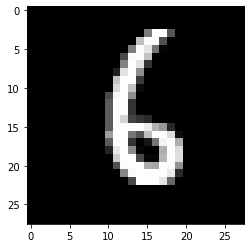

In [5]:
image, label = next(iter(train_loader))
print(f"image shape:{image.shape}, label shape:{label.shape}")
print(f"label:{label[0]}")
plt.imshow(image[0][0], cmap="gray")

Next we define a neural network.The network contains two convolutional layers, conv1 and conv2, followed by two linear layers as output, and finally outputs 10 dimensions. We use these 10 dimensions as the identifier of 0-9 to determine which number is recognized.

The input and output dimensions of each layer have been marked here as comments.

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1,28x28
        self.conv1 = nn.Conv2d(1,10,5) # 10, 24x24
        self.conv2 = nn.Conv2d(10,20,3) # 128, 10x10
        self.fc1 = nn.Linear(20*10*10,500)
        self.fc2 = nn.Linear(500,10)
    def forward(self,x):
        #x (batch_size(512), channels(1), height(28), width(28))
        batch_size = x.size(0)
        out = self.conv1(x) #512x10x24x24
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)  #512x20x12x12
        out = self.conv2(out) #512x20x10x10
        out = F.relu(out)
        out = out.view(batch_size,-1)#512x2000
        out = self.fc1(out)#512x500
        out = F.relu(out)
        out = self.fc2(out)#512x10
        out = F.log_softmax(out,dim=1)
        return out

We instantiate a network and use the .to method to move the network to the GPU after instantiation.

We also directly choose Adam.

In [7]:
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters()) #more details about Adam at https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

Next define the training function. We encapsulate all training operations into this function.

In [8]:
def train(model, device, train_loader, optimizer, epoch): # it's equal to the method "fit" of scikit-learn
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()#why need to call zero_grad():https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        output = model(data)#the output is the prediction
        loss = F.nll_loss(output, target)
        loss.backward()#equal to the backpropagation
        optimizer.step()#update the parameters
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

The test operation is also encapsulated into a function.

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # Add up the losses of a batch
            pred = output.max(1, keepdim=True)[1] # Find the index with the greatest probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Let's start the training. The benefits of encapsulation are reflected here. Just write two lines.

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.430581
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.252417
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.159174

Test set: Average loss: 0.0863, Accuracy: 9749/10000 (97%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.086607
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.086694
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.071649

Test set: Average loss: 0.0552, Accuracy: 9828/10000 (98%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.051280
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.047238
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.056056

Test set: Average loss: 0.0538, Accuracy: 9828/10000 (98%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.037606
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.059946
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.024784

Test set: Average loss: 0.0438, Accuracy: 9860/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.021791
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.019826
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.026461

Test 

Let's take a look at the result, the accuracy is 99%, no problem.

Finally let’s visualize the correct and incorrect examples.

the correct case:
the label of the data image:8
the predict of the data image:8
the data image:


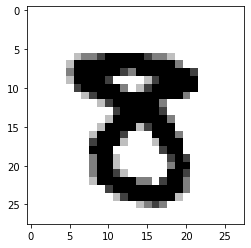

In [45]:
for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    correct_index = torch.where(torch.squeeze(pred)==target)
    if(len(correct_index[0])!=0):
        # the correct case
        print(f'the correct case:')
        print(f'the label of the data image:{target[correct_index[0][0]]}')
        print(f'the predict of the data image:{torch.squeeze(pred[correct_index[0][0]])}')
        print(f'the data image:')
        plt.imshow(data[correct_index[0][0]].cpu().reshape(28,28), cmap=plt.cm.gray_r)
        break

the incorrect case:
the label of the data image:9
the predict of the data image:7
the data image:


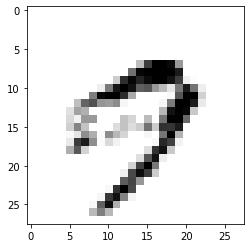

In [47]:
for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    incorrect_index = torch.where(torch.squeeze(pred)!=target)
    if(len(incorrect_index[0])!=0):
        # the incorrect case
        print(f'the incorrect case:')
        print(f'the label of the data image:{target[incorrect_index[0][0]]}')
        print(f'the predict of the data image:{torch.squeeze(pred[incorrect_index[0][0]])}')
        print(f'the data image:')
        plt.imshow(data[incorrect_index[0][0]].cpu().reshape(28,28), cmap=plt.cm.gray_r)
        break

MNIST is a very simple data set. Due to its limitations, it can only be used for research purposes and brings very limited value to practical applications. But through this example, we can fully understand the workflow of an actual project

We import the data set, preprocess the data, define our model, adjust the hyperparameters, test the training, and then adjust the hyperparameters or adjust the model through the training results.

Through this, we already have a good template. Future projects can use this template as an example.